In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import support_functions as sf

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

import copy
# sharp plots with higher resolution
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def gaussian_generator(center, eig_val, eig_vec, size):
    sigma = np.matmul(np.matmul(eig_vec, eig_val), np.transpose(eig_vec))
    data_set = np.random.multivariate_normal(center, sigma, size)

    return data_set

In [31]:
n_1 = 1000  # number of the elements
mu_1 = np.array([0, 0])  # center (centroid)

# sigma is expected to be positive  semi-definite matrix
w_1 = np.array([[1.5, 0], [0, 4.5]])  # eigenvalues
v_1 = np.array([[0.4, 0], [0, 0.4]])  # eigenvectors

data_set = gaussian_generator(mu_1,w_1, v_1, n_1)


rotation_angle = np.pi / 2
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])

coord_data = np.transpose(data_set[:, 0:2])
data_set[:, 0:2] = np.transpose(np.matmul(rotation_matrix, coord_data))

#data_set_0 = data_set[data_set[:, -1] == 0]
#data_set_1 = data_set[data_set[:, -1] == 1]


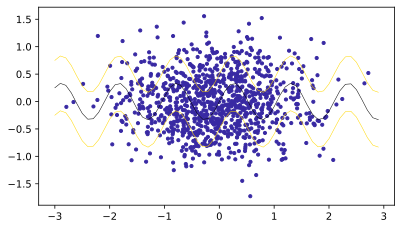

In [32]:
theta = np.linspace(-3, 3, 60, endpoint=False)

hyper_surface = np.sin(theta * 6) / 3
support_surface_1 = hyper_surface - 0.5
support_surface_2 = hyper_surface + 0.5

fig_1, ax_11 = plt.subplots()
ax_11.scatter(data_set[:, 0], data_set[:, 1], color= '#3829a3', s=10)
ax_11.plot(theta, hyper_surface, color='black', linewidth=0.5)
ax_11.plot(theta, support_surface_1, color='gold', linewidth=0.5)
ax_11.plot(theta, support_surface_2, color='gold', linewidth=0.5)
#ax_11.scatter(data_set_1[:, 0], data_set_1[:, 1], color= '#e1177e', s=10)
ax_11.set_aspect('equal')


plt.show()

In [33]:
# generate labels
data_set_0 = data_set[data_set[:, -1] <= np.sin(data_set[:, 0] * 6) / 2 - 0.5]
data_set_1 = data_set[data_set[:, -1] >= np.sin(data_set[:, 0] * 6) / 2 + 0.5]
data_set_m = data_set[(data_set[:, -1] > np.sin(data_set[:, 0] * 6) / 2 - 0.5) & (data_set[:, -1] < np.sin(data_set[:, 0] * 6) / 2 + 0.5)]
np.random.shuffle(data_set_m)
data_set_m_0, data_set_m_1 = train_test_split(data_set_m, train_size=0.5, test_size=0.5)

data_set_0 = np.vstack([data_set_0, data_set_m_0])
data_set_1 = np.vstack([data_set_1, data_set_m_1])

data_set_0 = np.hstack([data_set_0, np.zeros((len(data_set_0), 1))])
data_set_1 = np.hstack([data_set_1, np.ones((len(data_set_1), 1))])

data_set = np.vstack([data_set_0, data_set_1])
np.random.shuffle(data_set)

In [34]:
rotation_angle = np.pi / 4
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])

coord_data = np.transpose(data_set[:, 0:2])
data_set[:, 0:2] = np.transpose(np.matmul(rotation_matrix, coord_data))

data_set_0 = data_set[data_set[:, -1] == 0]
data_set_1 = data_set[data_set[:, -1] == 1]

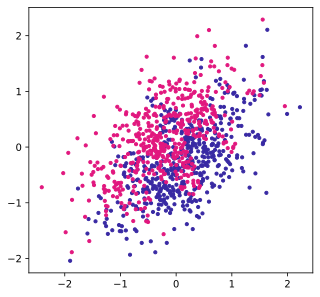

In [35]:
fig_2, ax_2 = plt.subplots()
ax_2.scatter(data_set_0[:, 0], data_set_0[:, 1], color= '#3829a3', s=10)
ax_2.scatter(data_set_1[:, 0], data_set_1[:, 1], color= '#e1177e', s=10)

ax_2.set_aspect('equal')

plt.show()